In [1]:
from pathlib import Path
import xarray as xr
from tabularbench.core.enums import BenchmarkOrigin
from tabularbench.results.ranking_table import make_ranking_table_, process_benchmark_results, process_sweep_results
from tabularbench.results.results_sweep import ResultsSweep
from tabularbench.config.config_benchmark_sweep import ConfigBenchmarkSweep
from tabularbench.results.scores_min_max import normalize_scores

cfg_general = ConfigBenchmarkSweep.load(Path("outputs_done/tabzilla_tabpfn_orig_finetune/tabpfn-default-tabzilla_has_completed_runs/config_benchmark_sweep.yaml"))
ds_benchmark = process_benchmark_results(cfg_general)
ds_benchmark['normalized_accuracy'] = normalize_scores(cfg_general, ds_benchmark['accuracy'])

def prepare_ds(txt: str, path: Path):
    cfg = cfg_general
    cfg_general.model_plot_name = txt
    results_sweep = ResultsSweep.load(path / "results_sweep.nc")
    ds = process_sweep_results(cfg, results_sweep)
    ds.coords['model_name'] = [cfg.model_plot_name]
    ds['normalized_accuracy'] = normalize_scores(cfg, ds['accuracy'])
    return ds

ds_tabpfn_original_zeroshot = prepare_ds("TabPFN (original) - Zero-shot", Path("outputs_done/tabzilla_tabpfn_orig_zeroshot/tabpfn-default-tabzilla_has_completed_runs"))
ds_tabpfn_original_finetune = prepare_ds("TabPFN (original) - Fine-tune", Path("outputs_done/tabzilla_tabpfn_orig_finetune/tabpfn-default-tabzilla_has_completed_runs"))
ds_tabpfn_retrained_zeroshot = prepare_ds("TabPFN (retrained) - Zero-shot", Path("outputs_done/tabzilla_tabpfn_foun_zeroshot/foundation-default-tabzilla_has_completed_runs"))
ds_tabpfn_retrained_finetune = prepare_ds("TabPFN (retrained) - Fine-tune", Path("outputs_done/tabzilla_tabpfn_foun_finetune/foundation-default-tabzilla_has_completed_runs"))
ds_tabforest_zeroshot = prepare_ds("TabForest - Zero-shot", Path("outputs_done/tabzilla_tabsgfd_zeroshot/foundation-default-tabzilla_has_completed_runs"))
ds_tabforest_finetune = prepare_ds("TabForest - Fine-tune", Path("outputs_done/tabzilla_tabsgfd_finetune/foundation-default-tabzilla_has_completed_runs"))
ds_tabforestpfn_zeroshot = prepare_ds("TabForestPFN - Zero-shot", Path("outputs_done/foundation_mix_600k_zeroshot/foundation-default-tabzilla_has_completed_runs"))
ds_tabforestpfn_finetune = prepare_ds("TabForestPFN - Fine-tune", Path("outputs_done/foundation_mix_600k_finetune/test_tabzilla_has_completed_runs"))


2024-04-30 16:24:06.449 | DEBUG    | tabularbench.results.scores_min_max:scores_min_max_:93 - For dataset id 3 and split train, we will normalize with min 0.9046 and max 1.0000
2024-04-30 16:24:06.462 | DEBUG    | tabularbench.results.scores_min_max:scores_min_max_:93 - For dataset id 3 and split valid, we will normalize with min 0.9000 and max 1.0000
2024-04-30 16:24:06.469 | DEBUG    | tabularbench.results.scores_min_max:scores_min_max_:93 - For dataset id 3 and split test, we will normalize with min 0.8966 and max 1.0000
2024-04-30 16:24:06.476 | DEBUG    | tabularbench.results.scores_min_max:scores_min_max_:93 - For dataset id 4 and split train, we will normalize with min 0.6444 and max 1.0000
2024-04-30 16:24:06.483 | DEBUG    | tabularbench.results.scores_min_max:scores_min_max_:93 - For dataset id 4 and split valid, we will normalize with min 0.6667 and max 1.0000
2024-04-30 16:24:06.490 | DEBUG    | tabularbench.results.scores_min_max:scores_min_max_:93 - For dataset id 4 and s

In [2]:
from tabularbench.core.enums import BenchmarkOrigin
from tabularbench.data.metadata import create_metadata

metadata = create_metadata(benchmark_origin=BenchmarkOrigin.TABZILLA)

In [3]:
import matplotlib.pyplot as plt
import pandas as pd


def create_comparison(ds_first: xr.Dataset, ds_second: xr.Dataset) -> pd.DataFrame:

    ds = xr.merge([ds_first, ds_second])
    ds = ds.sel(data_split='TEST').drop_vars('data_split')

    norm_acc_first = ds['normalized_accuracy'].sel(model_name=ds_first.coords['model_name']).values
    norm_acc_second = ds['normalized_accuracy'].sel(model_name=ds_second.coords['model_name']).values
    diff_normalized_accuracy = norm_acc_first - norm_acc_second

    n_observations = metadata.loc[ds.coords['openml_dataset_id']]['n_train']
    n_features = metadata.loc[ds.coords['openml_dataset_id']]['n_features']

    df_comparison = pd.DataFrame({
        'n_observations': n_observations,
        'n_features': n_features,
        'diff_normalized_accuracy': diff_normalized_accuracy.squeeze(),
    })

    return df_comparison


def create_plot(ax: plt.Axes, df_comparison: pd.DataFrame, title: str):

    scatter = ax.scatter(df_comparison['n_observations'], df_comparison['n_features'], c=df_comparison['diff_normalized_accuracy'], cmap='coolwarm', s=200, vmin=-0.2, vmax=0.2)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.xaxis.set_major_formatter(plt.ScalarFormatter())
    ax.yaxis.set_major_formatter(plt.ScalarFormatter())

    ax.set_xticks([100, 1000, 10000], labels=['100', '1000', '10000'], fontsize=14)
    ax.set_yticks([10, 100], labels=['10', '100'], fontsize=14)

    ax.set_xlabel('Number of observations', fontsize=16)
    ax.set_ylabel('Number of features', fontsize=16)

    ax.set_title(title, fontsize=20)

    # make colorbar
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', extend='both')
    cbar.ax.tick_params(labelsize=14)




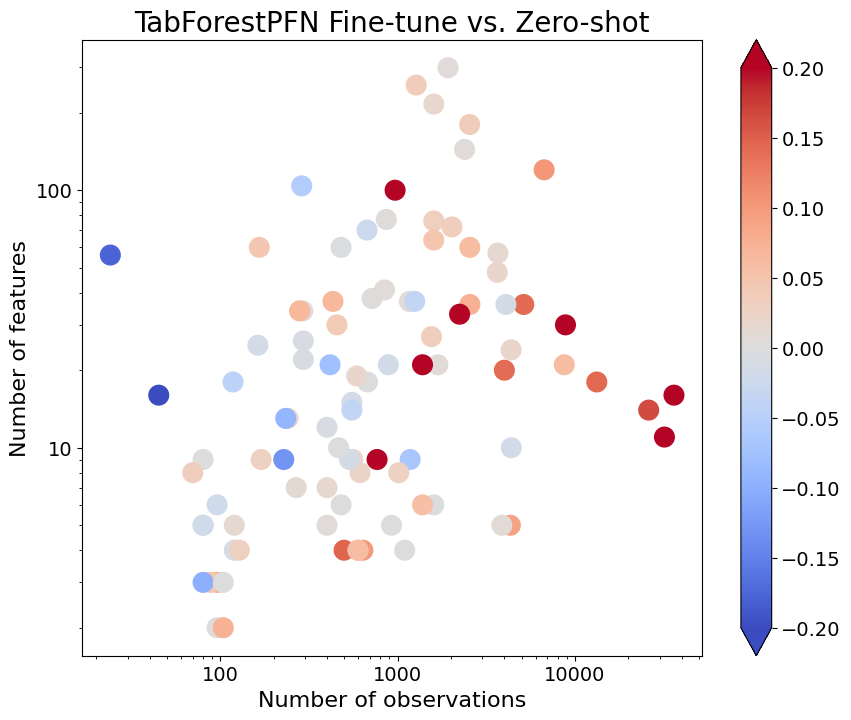

In [4]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

df_tabforestpfn_finetune_vs_zeroshot = create_comparison(ds_tabforestpfn_finetune, ds_tabforestpfn_zeroshot)
create_plot(axes, df_tabforestpfn_finetune_vs_zeroshot, 'TabForestPFN Fine-tune vs. Zero-shot')


In [5]:
fig.savefig('finetune_vs_zeroshot.pdf')

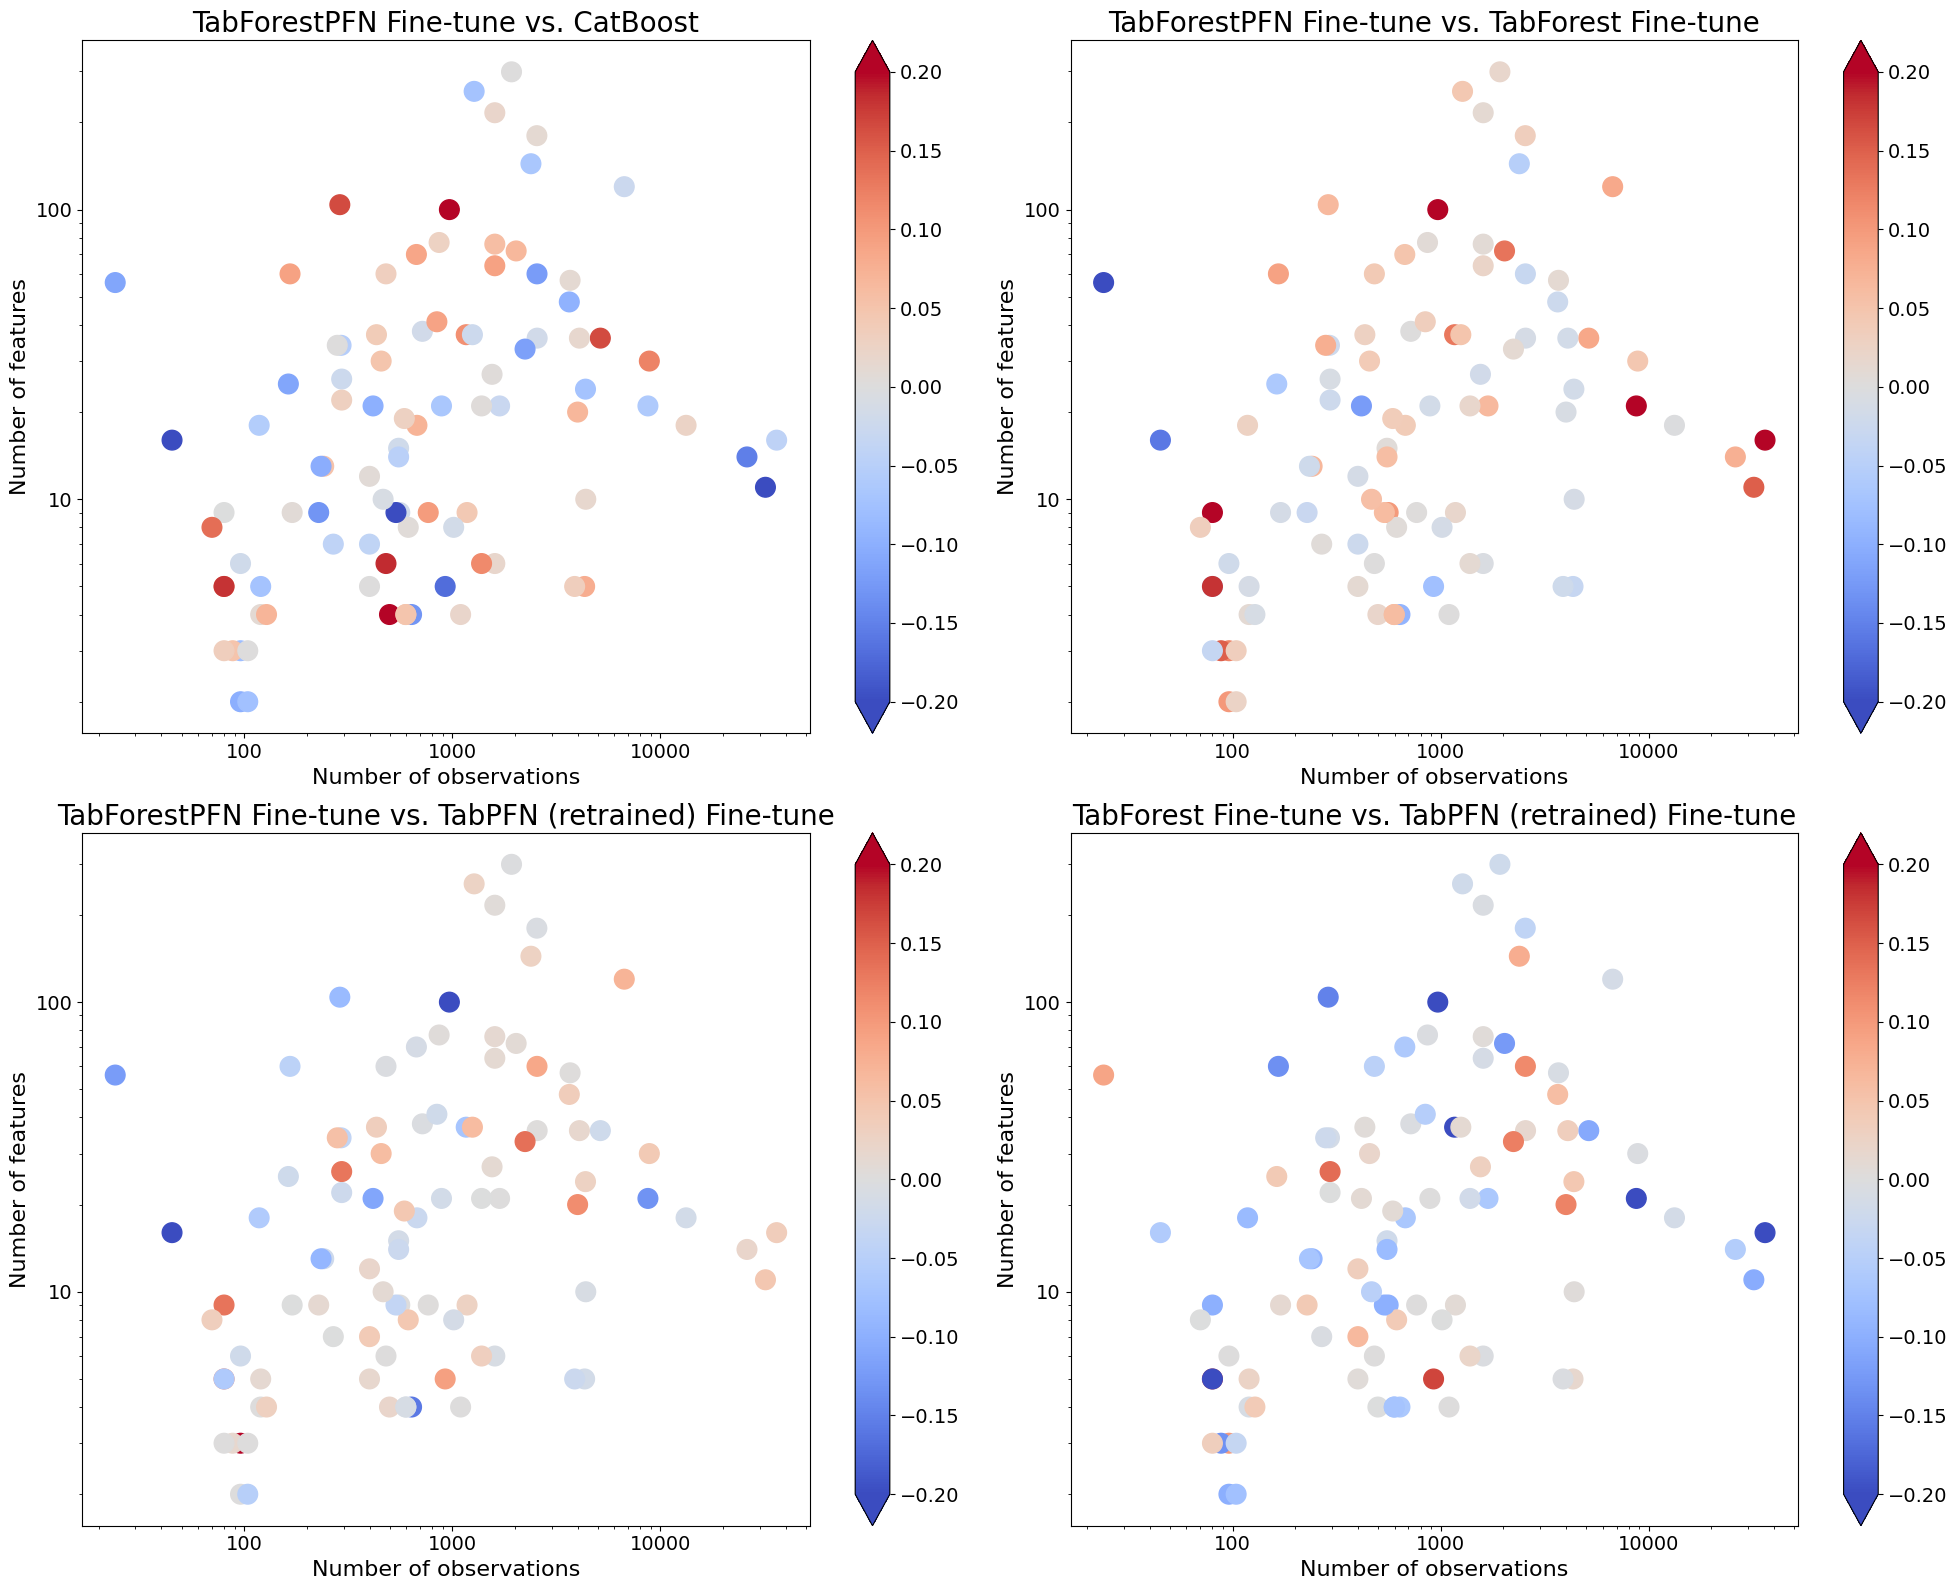

In [6]:
from tabularbench.core.enums import ModelName


fig, axes = plt.subplots(2, 2, figsize=(20, 16))

df_tabforestpfn_vs_catboost = create_comparison(ds_tabforestpfn_finetune, ds_benchmark.sel(model_name=[ModelName.CATBOOST.name]))
create_plot(axes[0, 0], df_tabforestpfn_vs_catboost, 'TabForestPFN Fine-tune vs. CatBoost')

df_tabforestpfn_vs_tabforest = create_comparison(ds_tabforestpfn_finetune, ds_tabforest_finetune)
create_plot(axes[0, 1], df_tabforestpfn_vs_tabforest, 'TabForestPFN Fine-tune vs. TabForest Fine-tune')

df_tabforestpfn_vs_tabpfn = create_comparison(ds_tabforestpfn_finetune, ds_tabpfn_retrained_finetune)
create_plot(axes[1, 0], df_tabforestpfn_vs_tabpfn, 'TabForestPFN Fine-tune vs. TabPFN (retrained) Fine-tune')

df_tabforest_vs_tabpfn = create_comparison(ds_tabforest_finetune, ds_tabpfn_retrained_finetune)
create_plot(axes[1, 1], df_tabforest_vs_tabpfn, 'TabForest Fine-tune vs. TabPFN (retrained) Fine-tune')

plt.tight_layout()


In [7]:
fig.savefig("dual_comparison.pdf")

In [8]:
(df_tabforestpfn_finetune_vs_zeroshot['diff_normalized_accuracy'] > 0).sum() / len(df_tabforestpfn_finetune_vs_zeroshot)

0.6595744680851063

In [9]:
df_tabforestpfn_finetune_vs_zeroshot_small = df_tabforestpfn_finetune_vs_zeroshot[ df_tabforestpfn_finetune_vs_zeroshot['n_observations'] < 1000 ]

(df_tabforestpfn_finetune_vs_zeroshot_small['diff_normalized_accuracy'] > 0).sum() / len(df_tabforestpfn_finetune_vs_zeroshot_small)

0.543859649122807

In [10]:
df_tabforestpfn_finetune_vs_zeroshot_large = df_tabforestpfn_finetune_vs_zeroshot[ df_tabforestpfn_finetune_vs_zeroshot['n_observations'] > 1000 ]

(df_tabforestpfn_finetune_vs_zeroshot_large['diff_normalized_accuracy'] > 0).sum() / len(df_tabforestpfn_finetune_vs_zeroshot_large)

0.8378378378378378

In [11]:
len(df_tabforestpfn_finetune_vs_zeroshot_small) * 0.544

31.008000000000003